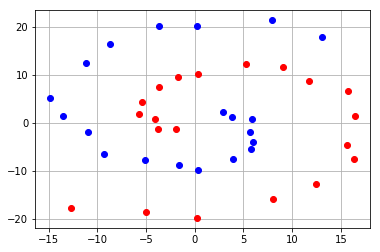

In [71]:
import random as random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier



#데이터 생성 단계입니다. (x*sin(x), x*cos(x)) 형태의 점들을 그러줍니다.
#그 점들에 약간의 랜덤값을 더해주었습니다.
seed=np.add(3,range(20))
rand=[]
for i in range(0,20):
    rand.append(random.random())

x_plus=np.add(np.multiply(seed,np.sin(np.divide(seed,10/pi))),0.2*np.multiply(seed,rand))
y_plus=np.add(np.multiply(seed,np.cos(np.divide(seed,10/pi))),0.2*np.multiply(seed,rand))
x_minus=np.add(np.multiply(seed,np.sin(np.divide(seed,-10/pi))),0.2*np.multiply(seed,rand))
y_minus=np.add(np.multiply(seed,-np.cos(np.divide(seed,10/pi))),0.2*np.multiply(seed,rand))

class1= pd.concat([pd.DataFrame(x_plus),pd.DataFrame(y_plus)],axis=1)
class2= pd.concat([pd.DataFrame(x_minus),pd.DataFrame(y_minus)],axis=1)
tutorial_sample=class1.append(class2)

#tutorial_sample로 지정된 변수가 앞으로 학습시킬 데이터 입니다.
#Y가 라벨이며 (1이 파란색, 0이 빨간색) Y1은 1, -1로 변환시킨 라벨 입니다.
Y_sample=np.append(np.array([1]*20),np.array([0]*20))
Y1_sample=np.subtract(np.multiply(2,Y_sample), 1)
W=np.array([0.025]*40)


plt.plot(x_plus,y_plus, 'bo', x_minus,y_minus,'ro')
plt.grid()
plt.show()



In [72]:
#단순하게 어떤 값 초과이면 1, 이하이면 0을 반환하는 분류기입니다.
#Input으로는 차례대로 분류할 데이터(X), 기준이 되는 변수 (여기서는 0=X, 1=Y), 기준점, 초과/미만일때 1 여부
#이며 Output은 X를 해당 기준으로 분류한 결과입니다.
def classifier (X,variable,thresh=3,plus=1):
    classify=[]
    if plus==1:
        for i in range(0,len(X.index)):
            if X.iloc[i,variable]>thresh:
                classify.append(1)
            else:
                classify.append(0)
        return classify
    else:
        for i in range(0,len(X.index)):
            if X.iloc[i,variable]<=thresh:
                classify.append(1)
            else:
                classify.append(0)
        return classify

print(classifier(tutorial_sample,0,0,1))

[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]


In [73]:
#선택된 변수가 지정된 Weight 하에서 error를 최소화 하는 지점을 찾아주는 함수입니다.
#Input으로는 독립변수,종속변수,Weight,i번째 독립변수들의 i값을 사용하며
#Output은 기준점 초과를 1이라고 판단했을 때 최적의 기준점, 그 때의 에러, 기준점 이하를 1이라고 판단했을 때
#최적의 기준점, 그 때의 에러입니다.
def part(X,Y,W,variable):
    thresh=-20
    correction=thresh+1
    error_vec=[]
    for i in range(0,40):
        thresh=thresh+1
        estimate = classifier(X, variable,thresh=thresh,plus=1)
        False_Estimate = Y !=  estimate
        error = sum(np.multiply(W, False_Estimate))
        error_vec.append(error)
    return np.array([np.argmin(error_vec)+correction,np.min(error_vec),np.argmax(error_vec)+correction,np.min(np.subtract(1,error_vec))])

print(part(tutorial_sample,Y_sample,W,0))

[-19.      0.5     8.      0.325]


In [74]:
#모든 독립변수들에 대해 최적의 기준점 및 그때의 에러를 반환해 주는 함수입니다. 지금은 X,Y에 해당하는 값을 반환합니다.
#Input은 앞으로 변화가 많이 없으니 설명을 생략하겠습니다.

def selector(X,Y,W):
    stack=pd.DataFrame()
    for i in range(0,2):
        part_result=pd.DataFrame(part(X,Y,W,i))
        stack=pd.concat([stack,part_result],axis=1)
    stack.columns = ['X', 'Y']
    stack.index = ['thresh_초과', 'error_초과', 'thresh_이하', 'error_이하']
    return stack

print(selector(tutorial_sample,Y_sample,W))

                X       Y
thresh_초과 -19.000 -12.000
error_초과    0.500   0.375
thresh_이하   8.000   3.000
error_이하    0.325   0.475


In [75]:
#selector 함수에서 error가 최소인 기준을 토대로 X를 한번 분류한 결과를 보여줍니다.
#Output은 분류결과, 분류에 사용된 변수 (0=X, 1=Y), 기준점, 초과/이하 여부 입니다

def stumped_tree(X,Y,W):
    selected=selector(X,Y,W)
    error_from_variables=selected.iloc[1,:].append(selected.iloc[3,:])
    if np.min(error_from_variables)==selected.iloc[1,0]:
        return[classifier(X,0,selected.iloc[0,0],1),0,selected.iloc[0,0],1]
    elif np.min(error_from_variables)==selected.iloc[1,1]:
        return [classifier(X,1,selected.iloc[0,1],1),1,selected.iloc[0,1],1]
    elif np.min(error_from_variables)==selected.iloc[3,0]:
        return [classifier(X,0,selected.iloc[2,0],0),0,selected.iloc[2,0],0]
    else:
        return [classifier(X,1,selected.iloc[2,1],0),1,selected.iloc[2,1],0]
    
print(stumped_tree(tutorial_sample,Y_sample,W))

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1], 0, 8.0, 0]


In [76]:
#분류를 한번 진행했을 때 Adaboost에 필요한 재료들을 반환하는 함수입니다.
#Output은 차례대로 변환된 Weight, alpha, epsilon, 1단계 분류 결과 입니다.


def result(X,Y,W):
    True_False=stumped_tree(X,Y,W)[0]==Y
    temp_result=np.subtract(np.multiply(2,stumped_tree(X,Y,W)[0]),1)
    epsilon=1-sum(np.multiply(W,True_False))
    alpha=0.5*np.log((1-epsilon)/epsilon)
    True_False=np.subtract(np.multiply(2,True_False),1)
    numerator=np.multiply(W,np.exp(np.multiply(-alpha,True_False)))
    denominator=sum(numerator)
    W2=np.divide(numerator,denominator)
    return [W2,alpha,epsilon,temp_result]

print(result(tutorial_sample,Y_sample,W))


[array([ 0.01851852,  0.01851852,  0.01851852,  0.01851852,  0.01851852,
        0.01851852,  0.01851852,  0.01851852,  0.01851852,  0.01851852,
        0.01851852,  0.01851852,  0.01851852,  0.01851852,  0.01851852,
        0.01851852,  0.01851852,  0.01851852,  0.01851852,  0.03846154,
        0.03846154,  0.03846154,  0.03846154,  0.03846154,  0.03846154,
        0.03846154,  0.03846154,  0.03846154,  0.03846154,  0.01851852,
        0.01851852,  0.01851852,  0.01851852,  0.01851852,  0.01851852,
        0.01851852,  0.01851852,  0.03846154,  0.03846154,  0.03846154]), 0.36544375427139675, 0.32499999999999973, array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1,
       -1, -1, -1,  1,  1,  1])]


In [77]:
#위 함수들을 결합하여 최종적으로 Adaboost를 실행하는 함수입니다.
#X를 나누는 기준을 학습시켜 A를 분류해주며 thresh값은 정확도를 어느 정도 까지 분류할지를 정해주는 parameter입니다.
#조금 시간이 걸려 learning step, predicting step단계를 print하게 만들었습니다.
#Output은 최종 분류결과/단계별 분류기준점/알파/분류기준 변수/초과 이하구분 입니다.
def Adaboost(X,Y,A,thresh=0.1):
    W=[1/len(X.index)]*len(X.index)
    estimate=np.multiply(0,result(X,Y,W)[3])
    final_error = 0.5
    variable = []
    critical = []
    plus_minus = []
    alpha = []
    predict=0
    count = 0
    A=np.reshape(A,(-1,2))
    A=pd.DataFrame(A)
    while final_error > thresh:
        epsilon = result(X,Y, W)[2]
        count = count + 1
        alpha.append(result(X,Y, W)[1])
        estimate = estimate + np.multiply(result(X,Y, W)[1], result(X,Y, W)[3])
        final_classify = np.sign(estimate)
        Y1 = np.subtract(np.multiply(2, Y), 1)
        final_error = sum(final_classify != Y1) / len(Y1)
        W = result(X,Y, W)[0]
        print("step {} finished with error {} in learning".format(count, final_error))
    W=[1/len(X.index)]*len(X.index)
    for i in range(0,count):
        variable.append(stumped_tree(X,Y,W)[1])
        critical.append(stumped_tree(X,Y,W)[2])
        plus_minus.append(stumped_tree(X,Y,W)[3])
        W = result(X,Y, W)[0]
        predict=predict+np.multiply(alpha[i],np.subtract(np.multiply(2,classifier(A,variable[i],critical[i],plus_minus[i])),1))
        print("step {} finished in predicting".format(i+1))
    XY=[]
    for i in range(0,len(variable)):
        if variable[i]==0:
            XY.append("X")
        else:
            XY.append("Y")

    PM=[]
    for i in range(0, len(plus_minus)):
        if plus_minus[i] == 1:
            PM.append("초과이면 1")
    else:
            PM.append("이하이면 1")
    return[np.sign(predict),np.add(critical,0.5),alpha,XY,PM]


#자기 자신을 학습한 결과로 자신을 test 하는 것이기 때문에 모두 TRUE가 나와야 정상입니다
print(Adaboost(tutorial_sample,Y_sample,tutorial_sample,0.01)[0]==Y1_sample)


step 1 finished with error 0.325 in learning
step 2 finished with error 0.375 in learning
step 3 finished with error 0.225 in learning
step 4 finished with error 0.25 in learning
step 5 finished with error 0.15 in learning
step 6 finished with error 0.05 in learning
step 7 finished with error 0.2 in learning
step 8 finished with error 0.1 in learning
step 9 finished with error 0.15 in learning
step 10 finished with error 0.05 in learning
step 11 finished with error 0.15 in learning
step 12 finished with error 0.0 in learning
step 1 finished in predicting
step 2 finished in predicting
step 3 finished in predicting
step 4 finished in predicting
step 5 finished in predicting
step 6 finished in predicting
step 7 finished in predicting
step 8 finished in predicting
step 9 finished in predicting
step 10 finished in predicting
step 11 finished in predicting
step 12 finished in predicting
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  T

In [78]:
#시각화를 위해 조금 더 간단한 예제를 만들어 보겠습니다
#X로 TRAIN한 ADABOOST CLASSIFIER가 test를 잘 분류하는지 확인해보기 위한 데이터셋 구성 단계입니다.

A=pd.DataFrame([2,6,4,7,9,4,8,3,2,6])
B=pd.DataFrame([3,4,1,1,1,8,5,3,7,2])
Y=np.array([1,1,0,0,1,0,1,1,0,0])
X=pd.concat([A,B],axis=1)
test=np.reshape([3,4,2,5,7,6,5,0],(-1,2))

result=Adaboost(X,Y,test,0.01)
print(result)


col_train=[]
for i in range(0,10):
    if Y[i]==1:
        col_train.append("b")
    else:
        col_train.append("r")
        

col = []
for i in range(0,4):
    if result[0][i]== 1:
        col.append("b")
    else:
        col.append("r")

        
col2=[]
for i in range(0,4):
    if result[0][i]==1:
        col2.append("r")
    else:
        col2.append("b")


step 1 finished with error 0.3 in learning
step 2 finished with error 0.3 in learning
step 3 finished with error 0.0 in learning
step 1 finished in predicting
step 2 finished in predicting
step 3 finished in predicting
[array([ 1.,  1., -1., -1.]), array([ 7.5,  2.5,  5.5]), [0.42364893019360172, 0.64964149206512978, 0.92291334524916491], ['X', 'Y', 'Y'], ['초과이면 1', '초과이면 1', '이하이면 1']]


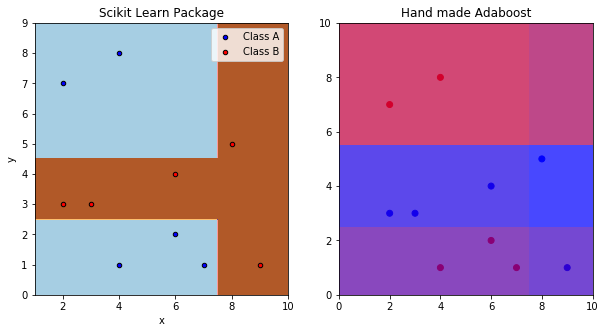

In [79]:
#분류 결과와 경계선을 눈으로 확인해 줍니다

y_practice=np.array([1,1,0,0,1,0,1,1,0,0])
X_practice=np.array([[2,3],[6,4],[4,1],[7,1],[9,1],[4,8],[8,5],[3,3],[2,7],[6,2]])


#Adaboost 패키지의 옵션들을 설명드리겠습니다.
#base_estimator는 분류기의 종류입니다. 저희는 Stump Tree를 사용했기에 기본 분류기에 depth1을 사용하였습니다.
#algorithm 에는 SAMME과 SAMME.R이 있습니다. SAMME이 저희가 배운 알고리즘이며 SAMME.R은 분류 결과를 실수 (REAL)
#로 출력합니다. 원리는 INPUT에 대한 Likelyhood와 비슷한 지표 h를 만들어 h를 최대로 하는 OUTPUT 값을 출력합니다.
#Emprically SAMME보다 성능이 좋고 빠르게 수렴한다고 합니다.
#Learning Rate는 Boost에 사용된 분류기 결과를 얼마나 사용할 지를 결정하는 Parameter 입니다. 저희가 배운 내용에서는
#따로 discount를 하지 않기에 1로 설정합니다.
#n_estimators 는 최대 몇번까지 분류할지를 결정하는 parameter입니다.

bdt = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",learning_rate=1.0, random_state=None,
                         n_estimators=200)

bdt.fit(X_practice, y_practice)


plot_colors = "br"
plot_step = 0.02
class_names = "AB"

plt.figure(figsize=(10, 5))

# Plot the decision boundaries
plt.subplot(121)
x_min, x_max = X_practice[:, 0].min() - 1, X_practice[:, 0].max() + 1
y_min, y_max = X_practice[:, 1].min() - 1, X_practice[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

Z = bdt.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.axis("tight")

# Plot the training points
for i, n, c in zip(range(2), class_names, plot_colors):
    idx = np.where(y_practice == i)
    plt.scatter(X_practice[idx, 0], X_practice[idx, 1],
                c=c, cmap=plt.cm.Paired,
                s=20, edgecolor='k',
                label="Class %s" % n)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(loc='upper right')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scikit Learn Package')



plt.subplot(122)

plt.xlim(0, 10)
plt.ylim(0, 10)


plt.axvspan(7.5, 10, facecolor='b', alpha=0.5*0.424)
plt.axvspan(7.5, 0, facecolor='r', alpha=0.5*0.424)
plt.axhspan(2.5, 10, facecolor='b', alpha=0.5*0.649)
plt.axhspan(2.5, 0, facecolor='r', alpha=0.5*0.649)
plt.axhspan(5.5, 0, facecolor='b', alpha=0.5*0.923)
plt.axhspan(5.5, 10, facecolor='r', alpha=0.5*0.923)
plt.scatter(A,B,c=col_train)
plt.title('Hand made Adaboost')
plt.show()



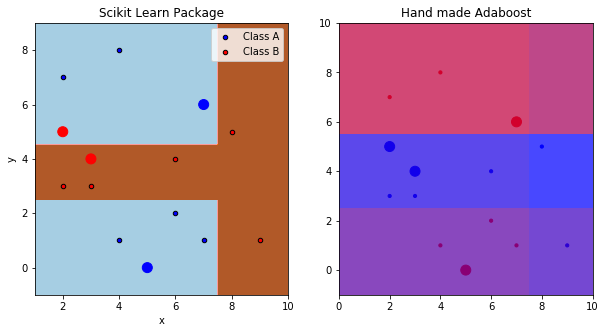

In [80]:
#test에 활용된 점들은 점의 크기를 조금 더 크게 표시하였습니다

bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=200)

bdt.fit(X_practice, y_practice)

plot_colors = "br"
plot_step = 0.02
class_names = "AB"

plt.figure(figsize=(10, 5))

# Plot the decision boundaries
plt.subplot(121)
x_min, x_max = X_practice[:, 0].min() - 1, X_practice[:, 0].max() + 1
y_min, y_max = X_practice[:, 1].min() - 1, X_practice[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min-1, y_max, plot_step))

Z = bdt.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.axis("tight")

# Plot the training points
for i, n, c in zip(range(2), class_names, plot_colors):
    idx = np.where(y_practice == i)
    plt.scatter(X_practice[idx, 0], X_practice[idx, 1],
                c=c, cmap=plt.cm.Paired,
                s=20, edgecolor='k',
                label="Class %s" % n)
plt.xlim(x_min, x_max)
plt.ylim(y_min-1, y_max)
plt.legend(loc='upper right')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(test[:,0],test[:,1],c=col2,s=100)
plt.title('Scikit Learn Package')




plt.subplot(122)

plt.xlim(0, 10)
plt.ylim(-1, 10)


plt.axvspan(7.5, 10, facecolor='b', alpha=0.5*0.424)
plt.axvspan(7.5, -1, facecolor='r', alpha=0.5*0.424)
plt.axhspan(2.5, 10, facecolor='b', alpha=0.5*0.649)
plt.axhspan(2.5, -1, facecolor='r', alpha=0.5*0.649)
plt.axhspan(5.5, -1, facecolor='b', alpha=0.5*0.923)
plt.axhspan(5.5, 10, facecolor='r', alpha=0.5*0.923)
plt.scatter(A,B,c=col_train,s=10)
plt.title('Hand made Adaboost')
plt.scatter(test[:,0],test[:,1],c=col,s=100)
plt.show()


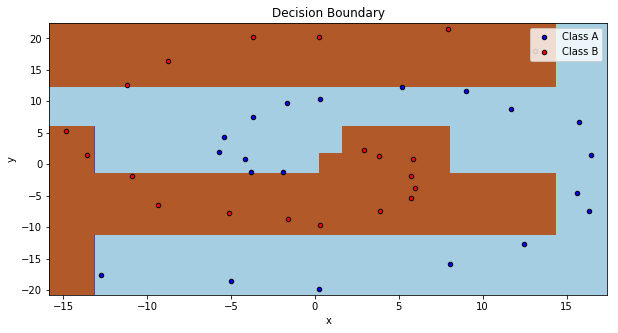

In [81]:
#마지막으로 tutorial_sample의 분류경계면입니다.

Y=np.append(np.array([1]*20),np.array([0]*20))
tutorial_sample=np.array(tutorial_sample)

# Create and fit an AdaBoosted decision tree
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=200)

bdt.fit(tutorial_sample,Y_sample)


plot_colors = "br"
plot_step = 0.02
class_names = "AB"

plt.figure(figsize=(10, 5))

# Plot the decision boundaries
x_min, x_max = tutorial_sample[:, 0].min() - 1, tutorial_sample[:, 0].max() + 1
y_min, y_max = tutorial_sample[:, 1].min() - 1, tutorial_sample[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

Z = bdt.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.axis("tight")

# Plot the training points
for i, n, c in zip(range(2), class_names, plot_colors):
    idx = np.where(Y_sample== i)
    plt.scatter(tutorial_sample[idx, 0], tutorial_sample[idx, 1],
                c=c, cmap=plt.cm.Paired,
                s=20, edgecolor='k',
                label="Class %s" % n)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(loc='upper right')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Decision Boundary')
plt.show()